In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def print_model_structure(model_name="Qwen/Qwen3-0.6B", max_layers=10):
    # load tokenizer + model
    print(f"Loading model {model_name} ...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map='auto')
    model.eval()

    # Print top-level modules
    print("\n=== Top-level modules ===")
    for name, module in model.named_children():
        print(f"{name}: {module.__class__.__name__}")

    # Print some layers in one of the blocks (assumes standard transformer block naming)
    print("\n\n=== First few transformer blocks details ===")
    try:
        blocks = model.model.decoder.layers  # this may differ depending on implementation
    except AttributeError:
        # fallback if structure slightly different
        blocks = [m for n, m in model.named_modules() if "layer" in n.lower()][0:max_layers]

    for i, blk in enumerate(blocks[:max_layers]):
        print(f"\n--- Block {i} ({blk.__class__.__name__}) ---")
        for name, subm in blk.named_children():
            print(f"   {name}: {subm.__class__.__name__}")

    # Print parameter counts
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

if __name__ == "__main__":
    print_model_structure()


/home/maria/Infino/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model Qwen/Qwen3-0.6B ...


`torch_dtype` is deprecated! Use `dtype` instead!



=== Top-level modules ===
model: Qwen3Model
lm_head: Linear


=== First few transformer blocks details ===

--- Block 0 (ModuleList) ---
   0: Qwen3DecoderLayer
   1: Qwen3DecoderLayer
   2: Qwen3DecoderLayer
   3: Qwen3DecoderLayer
   4: Qwen3DecoderLayer
   5: Qwen3DecoderLayer
   6: Qwen3DecoderLayer
   7: Qwen3DecoderLayer
   8: Qwen3DecoderLayer
   9: Qwen3DecoderLayer
   10: Qwen3DecoderLayer
   11: Qwen3DecoderLayer
   12: Qwen3DecoderLayer
   13: Qwen3DecoderLayer
   14: Qwen3DecoderLayer
   15: Qwen3DecoderLayer
   16: Qwen3DecoderLayer
   17: Qwen3DecoderLayer
   18: Qwen3DecoderLayer
   19: Qwen3DecoderLayer
   20: Qwen3DecoderLayer
   21: Qwen3DecoderLayer
   22: Qwen3DecoderLayer
   23: Qwen3DecoderLayer
   24: Qwen3DecoderLayer
   25: Qwen3DecoderLayer
   26: Qwen3DecoderLayer
   27: Qwen3DecoderLayer

--- Block 1 (Qwen3DecoderLayer) ---
   self_attn: Qwen3Attention
   mlp: Qwen3MLP
   input_layernorm: Qwen3RMSNorm
   post_attention_layernorm: Qwen3RMSNorm

--- Block 2 (

Captured 28 attention maps from 28 layers.
Graph: 448 nodes, 6912 edges
Sample path: ['L0_H0', 'L1_H0', 'L2_H0', 'L3_H0', 'L4_H0', 'L5_H0']


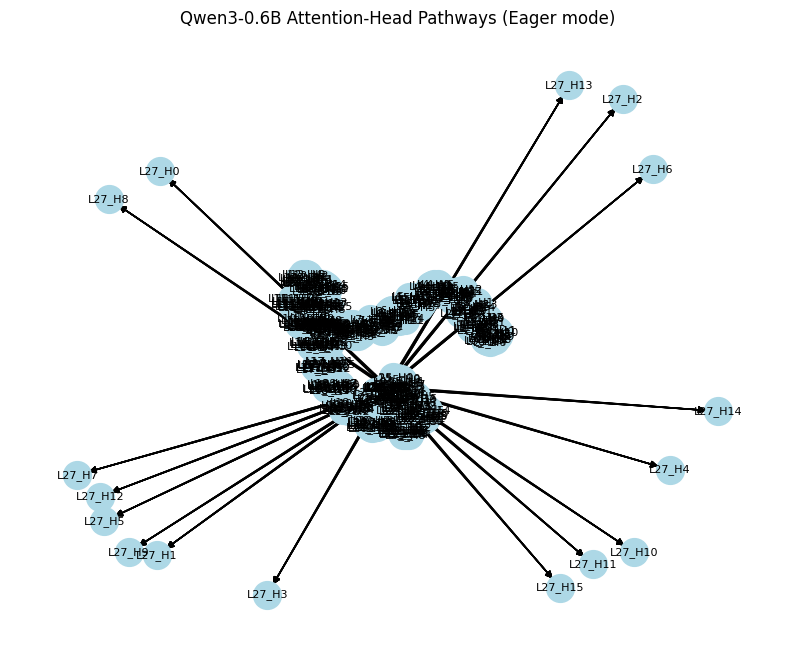

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import networkx as nx

# 1️⃣ Load model with attention outputs enabled via "eager" implementation
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="cpu",
    attn_implementation="eager",   # 👈 switch backend from SDPA → eager
)
model.config.output_attentions = True
model.eval()

# 2️⃣ Run a forward pass
prompt = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# 3️⃣ Extract attention maps
if getattr(outputs, "attentions", None) is None or outputs.attentions[0] is None:
    raise RuntimeError("Model did not return attentions — check eager mode.")

attn_maps = [att.mean(dim=(0, 2)).cpu() for att in outputs.attentions]  # (heads, key_len)
print(f"Captured {len(attn_maps)} attention maps from {len(attn_maps)} layers.")

# 4️⃣ Build inter-layer head graph
G = nx.DiGraph()
for l, attn in enumerate(attn_maps):
    num_heads = attn.shape[0]
    for h in range(num_heads):
        node = f"L{l}_H{h}"
        G.add_node(node)
        if l + 1 < len(attn_maps):
            for h2 in range(num_heads):
                weight = attn[h].mean().item()
                if weight > 0.05:
                    G.add_edge(node, f"L{l+1}_H{h2}", weight=weight)

print(f"Graph: {len(G.nodes)} nodes, {len(G.edges)} edges")

# 5️⃣ DFS through the graph
paths = []
def dfs(node, path):
    if len(path) > 5:
        paths.append(path)
        return
    for _, nxt in G.out_edges(node):
        dfs(nxt, path + [nxt])

if G.nodes:
    start = list(G.nodes)[0]
    dfs(start, [start])
    if paths:
        print("Sample path:", paths[0])

# 6️⃣ Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]["weight"] * 10 for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=400)
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Qwen3-0.6B Attention-Head Pathways (Eager mode)")
plt.axis("off")
plt.show()


Tokens: ['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', '.']
Target token 'fox' found at index 3 → token='Ġfox'
301 heads show noticeable attention to 'fox' out of 448 total.


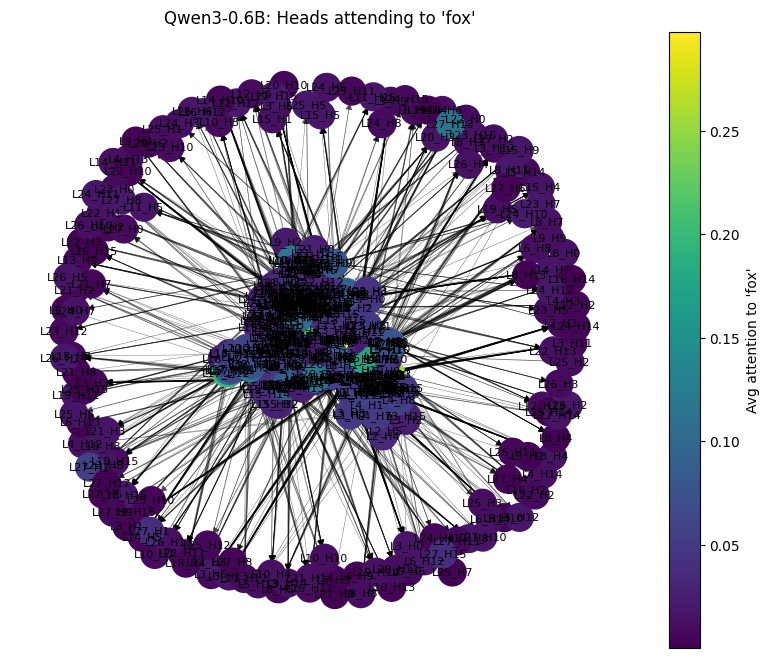

In [13]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import networkx as nx

# 1️⃣ Load model in eager mode (to get attention maps)
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="cpu",
    attn_implementation="eager",
)
model.config.output_attentions = True
model.eval()

# 2️⃣ Input text
prompt = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print("Tokens:", tokens)

# 3️⃣ Identify the index of "fox"
target_token = "fox"
try:
    fox_idx = tokens.index(target_token)
except ValueError:
    # Sometimes the tokenizer splits it differently (e.g., '▁fox' or 'Fox')
    for i, tok in enumerate(tokens):
        if "fox" in tok.lower():
            fox_idx = i
            break
print(f"Target token '{target_token}' found at index {fox_idx} → token='{tokens[fox_idx]}'")

# 4️⃣ Run the model with attentions
with torch.no_grad():
    outputs = model(**inputs)

attn_maps = outputs.attentions  # tuple of (layers, batch, heads, query, key)

# 5️⃣ Compute average attention *to 'fox'*
attn_to_fox = []
for layer, att in enumerate(attn_maps):
    # att shape: (1, n_heads, q_len, k_len)
    att = att[0]  # remove batch dim
    to_fox = att[:, :, fox_idx]  # attention to 'fox'
    attn_to_fox.append(to_fox.mean(dim=1).cpu())  # mean over queries -> per-head score

# --- 6️⃣ Build graph weighted by "fox-attention" intensity (robust) ---
G = nx.DiGraph()
for l, head_values in enumerate(attn_to_fox):
    num_heads = head_values.shape[0]
    for h in range(num_heads):
        node = f"L{l}_H{h}"
        strength = head_values[h].item()
        # Always create node, even if weak
        G.add_node(node, strength=strength)
        # Only connect if reasonably strong
        if l + 1 < len(attn_to_fox) and strength > 0.02:
            for h2 in range(num_heads):
                weight = (strength + attn_to_fox[l + 1][h2].item()) / 2
                if weight > 0.03:
                    G.add_edge(node, f"L{l+1}_H{h2}", weight=weight)

strong_heads = [n for n, d in G.nodes(data=True) if d["strength"] > 0.02]
print(f"{len(strong_heads)} heads show noticeable attention to '{target_token}' "
      f"out of {len(G.nodes)} total.")

# --- 7️⃣ Plot token-specific attention pathway (robust + colorbar fix) ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
node_colors = [G.nodes[n].get("strength", 0.0) for n in G.nodes()]
weights = [G[u][v].get("weight", 0.0) * 10 for u, v in G.edges()]

# draw nodes and keep handle to mappable
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap="viridis",
    node_size=400
)
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title(f"Qwen3-0.6B: Heads attending to '{target_token}'")
plt.axis("off")

# ✅ attach colorbar to the node collection
plt.colorbar(nodes, label=f"Avg attention to '{target_token}'")
plt.show()

